<a href="https://colab.research.google.com/github/Jezebel1990/03-05-2021/blob/main/implementacao_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Antes de iniciar este notebook, faça o upload dos arquivo com as imagens para treinamento (train_signs.h5), as imagens para validação (test_signs.h5).

In [4]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  #fazer upload dos arquivos: trains_signs.h5, test_signs.h5

Mounted at /content/drive


Saving test_signs.h5 to test_signs.h5
Saving train_signs.h5 to train_signs.h5
User uploaded file "test_signs.h5" with length 1477712 bytes
User uploaded file "train_signs.h5" with length 13281872 bytes


# **Introdução**

Neste notebook iremos implementar uma rede neural convolucional para identificação de números de 0 até 5, utilizando imagens de mãos humanas. Analisaremos também a evolução da função de custo e da acurácia durante a etapa de treinamento, utilizando os conjuntos de treinamento e de teste. Finalmente, após o treinamento da rede, será possível utilizar uma imagem  escolhida de forma aleatória para verificação do resultado de classificação do modelo. 

Importando as bibliotecas.

In [5]:
import keras
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras import datasets, layers, models


keras.backend.clear_session()

In [6]:
#conversão para one_hot
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
    
#extraindo os conjuntos
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])  
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

# carregando os exemplos
train_images, train_labels, test_images, test_labels, classes = load_dataset()

y = 2


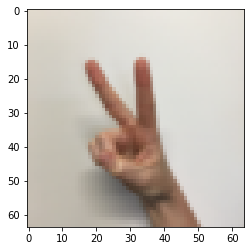

In [9]:
# Exemplo de uma figura
index = 4
plt.imshow(train_images[index])
print ("y = " + str(np.squeeze(train_labels[:, index])))

In [10]:
train_images = train_images/255. #normalização para range [0..1]->RGB é de [0..255]
test_images = test_images/255.   #normalização para range [0..1]->RGB é de [0..255]
train_labels = convert_to_one_hot(train_labels, 6).T
test_labels = convert_to_one_hot(test_labels, 6).T
train_labels =np.argmax(train_labels, axis=1)
test_labels =np.argmax(test_labels, axis=1)


#Verificando as dimensões dos conjuntos de entrada
print ("number of training examples = " + str(train_images.shape[0]))
print ("number of test examples = " + str(test_images.shape[0]))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels: " + str(test_labels.shape))
 

number of training examples = 1080
number of test examples = 120
train_images shape: (1080, 64, 64, 3)
train_labels shape: (1080,)
test_images shape: (120, 64, 64, 3)
test_labels: (120,)


Arquitetura da Rede


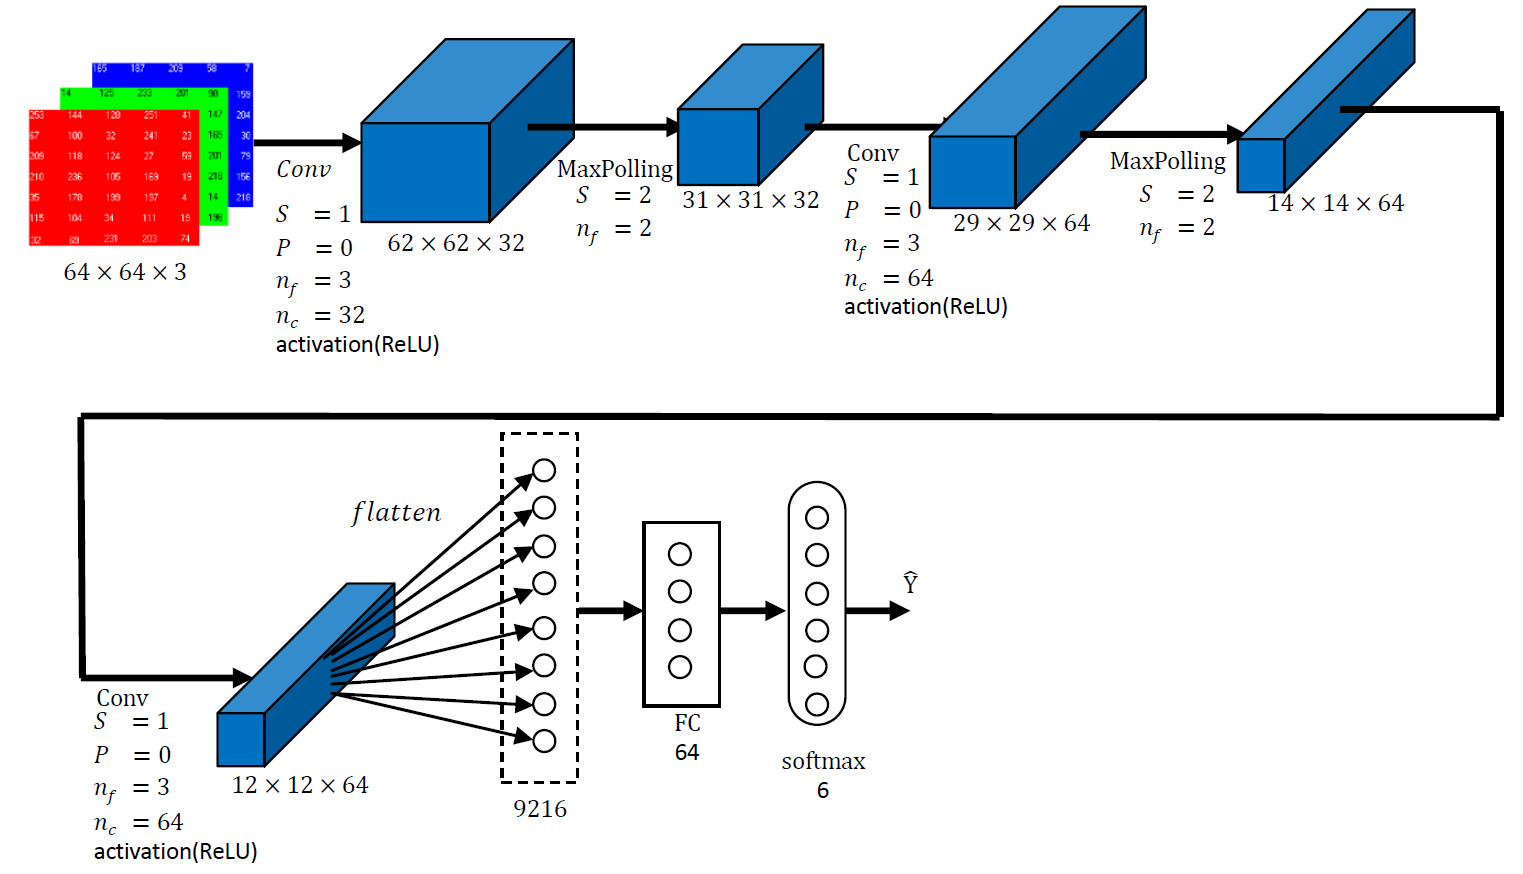

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32,kernel_size=(3, 3),strides=(1, 1), padding='valid', activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2),strides=(2, 2), padding='valid'))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(layers.MaxPooling2D((2, 2),strides=(2, 2), padding='valid'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 9216)              0

**Realizando o treinamento e validação da rede.**

Otimizador -> adam

Função de Custo->SparseCategoricalCrossentropy 

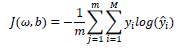

numero de épocas->epochs=10

tamanho do minibatch ->batch_size=None (sem utilização de minibatch)


In [13]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,batch_size=None, 
                    validation_data=(test_images, test_labels))

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


34/34 [==============================] - 7s 181ms/step - loss: 1.7953 - accuracy: 0.1972 - val_loss: 1.7569 - val_accuracy: 0.2250
Epoch 2/10
34/34 [==============================] - 6s 176ms/step - loss: 1.5212 - accuracy: 0.3880 - val_loss: 1.3371 - val_accuracy: 0.4750
Epoch 3/10
34/34 [==============================] - 6s 176ms/step - loss: 0.9724 - accuracy: 0.6380 - val_loss: 0.7806 - val_accuracy: 0.7167
Epoch 4/10
34/34 [==============================] - 6s 177ms/step - loss: 0.6817 - accuracy: 0.7685 - val_loss: 0.5025 - val_accuracy: 0.8417
Epoch 5/10
34/34 [==============================] - 6s 178ms/step - loss: 0.5327 - accuracy: 0.8176 - val_loss: 0.4319 - val_accuracy: 0.8500
Epoch 6/10
34/34 [==============================] - 6s 178ms/step - loss: 0.3397 - accuracy: 0.8815 - val_loss: 0.3337 - val_accuracy: 0.9083
Epoch 7/10
34/34 [==============================] - 7s 193ms/step - loss: 0.2636 - accuracy: 0.9194 - val_loss: 0.3994 - val_accuracy: 0.8500
Epoch 8/10
34/34 

**Gerando o gráfico de Acurácia para o conjunto de treinamento e validação**

4/4 - 0s - loss: 0.2464 - accuracy: 0.9167 - 175ms/epoch - 44ms/step


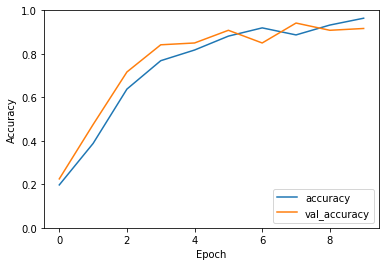

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)


**Gerando o gráfico da função Custo**

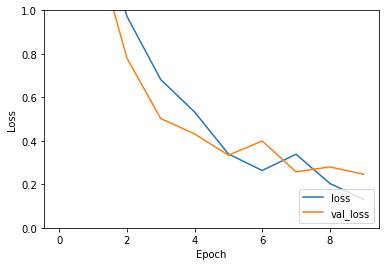

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

**Testando para uma imagem qualquer**

Fazendo o upload da(s) imagem(s)

In [16]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving download.jpg to download.jpg
Saving painel-redondo-snoopy-painel-desenho.jpg to painel-redondo-snoopy-painel-desenho.jpg
User uploaded file "download.jpg" with length 4187 bytes
User uploaded file "painel-redondo-snoopy-painel-desenho.jpg" with length 98993 bytes


**Usando a sua própria imagem para classificação após o aprendizado da rede.**

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


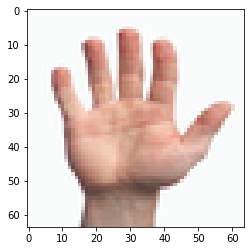

In [20]:
from PIL import Image

basewidth = 300
img = Image.open('download.jpg')
img = img.resize((64,64), Image.ANTIALIAS)
resized = np.array(img)
plt.imshow(resized)
resized = np.expand_dims(resized, axis=0) #transformando a imagem em um tensor.

predictions = model.predict(resized)# rede realizando a predição após o aprendizado
print((predictions.T)) #imprimindo a saída Softmax da rede

#train_image = train_images[102]
#plt.imshow(train_image)
#train_image = np.expand_dims(train_images[102], axis=0)

#predictions = model.predict(train_image)